# Pix2Pix

### Goals
This notebook contains the implementation of a generative model based on the paper [*Image-to-Image Translation with Conditional Adversarial Networks*](https://arxiv.org/abs/1611.07004) by Isola et al. 2017, also known as Pix2Pix.

The trained model would convert "raw" handwritten text images from the IAM dataset ("input" images that may contain elastic distortions and slopes and slants different from 0) in normalised handwritten text images ("output" images where distortions, slants and slopes have been removed). 

This has been done through paired image-to-image translation, the key concept behind the Pix2Pix model. The model will receive two different sets, the first of which will contain pre-processed images of handwritten words. In this set, the words have been normalised, which means that slopes and slants have been removed using classical algorithms. This would be the ground truth set. The second set will be created by performing son random operations (adding slants and/or slopes and/or elastic distortions) to the images in the first set, "unnormalising" them in the process. Therefore, given an image from the second set, the Pix2Pix network architecture should normalise the underlaying handwritten text, transforming that image into the corresponding image from the first, normalised set. 

Of course, the legibility of the word and the word itself must be preserved during the process.

The following figure has been taken from the aforementioned paper and reflects the paired image-to-image translation that we are pursuing:


![pix2pix example](pix2pix_ex.png)


## Getting Started
We will start by importing libraries and defining a visualization function.

In [29]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy import ndimage
import skimage 
import cv2
import numpy as np
import random
import math
import albumentations
import h5py
torch.manual_seed(0)

path = "/home/abarreiro/data/handwriting/seq2seq/IAM_words_48_192.hdf5"
path_raw = "/home/abarreiro/data/handwriting/seq2seq/IAM_words_48_192_non_preprocessed.hdf5"

# set display defaults
plt.rcParams['figure.figsize'] = (30, 30)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap


def show_tensor_images(image_tensor, num_images=12, size=(1, 48, 192)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
    return image_grid

# Inspecting hdf5 file with PREPROCESSED images

In [30]:
filename = path

with h5py.File(filename, "r") as f:
    # List all groups
    #print("Keys: %s" % f.keys())
    data_header = list(f.keys())
    print(data_header)
    data = []
    
    for item in data_header:
        
        # Getting data:
        data.append(list(f[item]))
        
    # Creating dictionary between data names and data   
    new_dict = {name: obj for name, obj in zip(data_header, data)}

['X_trn', 'X_tst', 'X_val', 'filename_trn', 'filename_tst', 'filename_val', 'image_length_trn', 'image_length_tst', 'image_length_val', 'target_dict_keys', 'target_dict_values', 'target_length_trn', 'target_length_tst', 'target_length_val', 'target_trn', 'target_tst', 'target_val']


# Inspecting hdf5 file with RAW images

In [31]:
filename = path_raw

with h5py.File(filename, "r") as f:
    # List all groups
    #print("Keys: %s" % f.keys())
    data_header = list(f.keys())
    print(data_header)
    data = []
    
    for item in data_header:
        
        # Getting data:
        data.append(list(f[item]))
        
    # Creating dictionary between data names and data   
    new_dict_raw = {name: obj for name, obj in zip(data_header, data)}

['X_trn', 'X_tst', 'X_val', 'target_trn', 'target_tst', 'target_val']


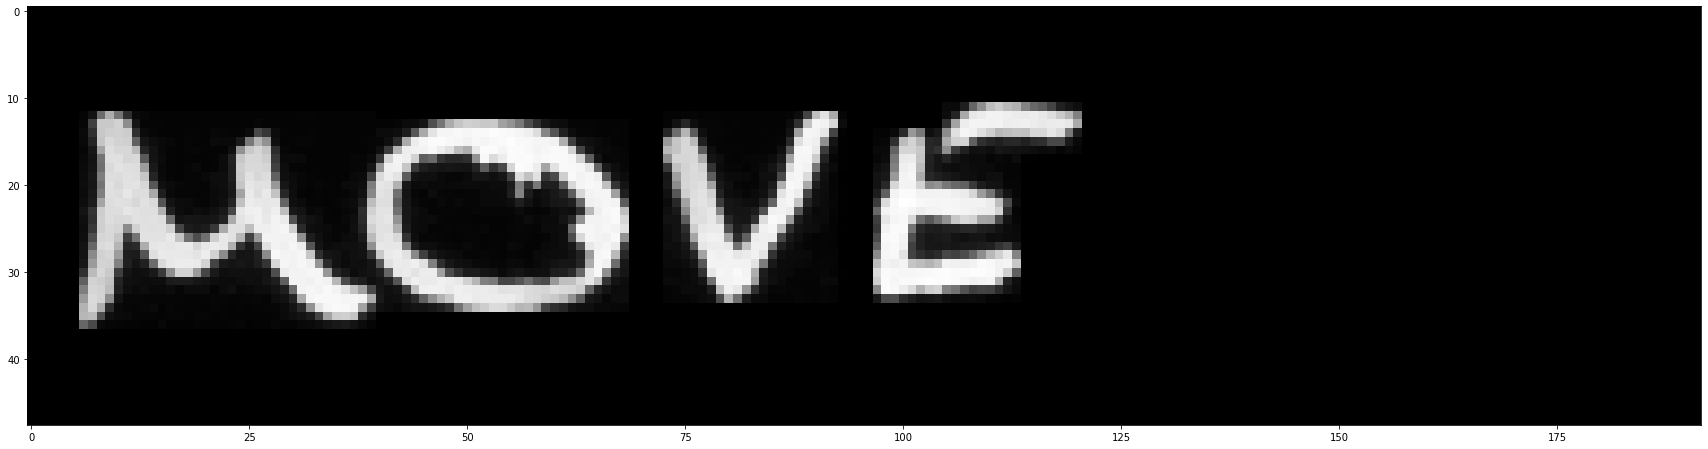

In [32]:
plt.imshow(new_dict_raw['X_trn'][1])

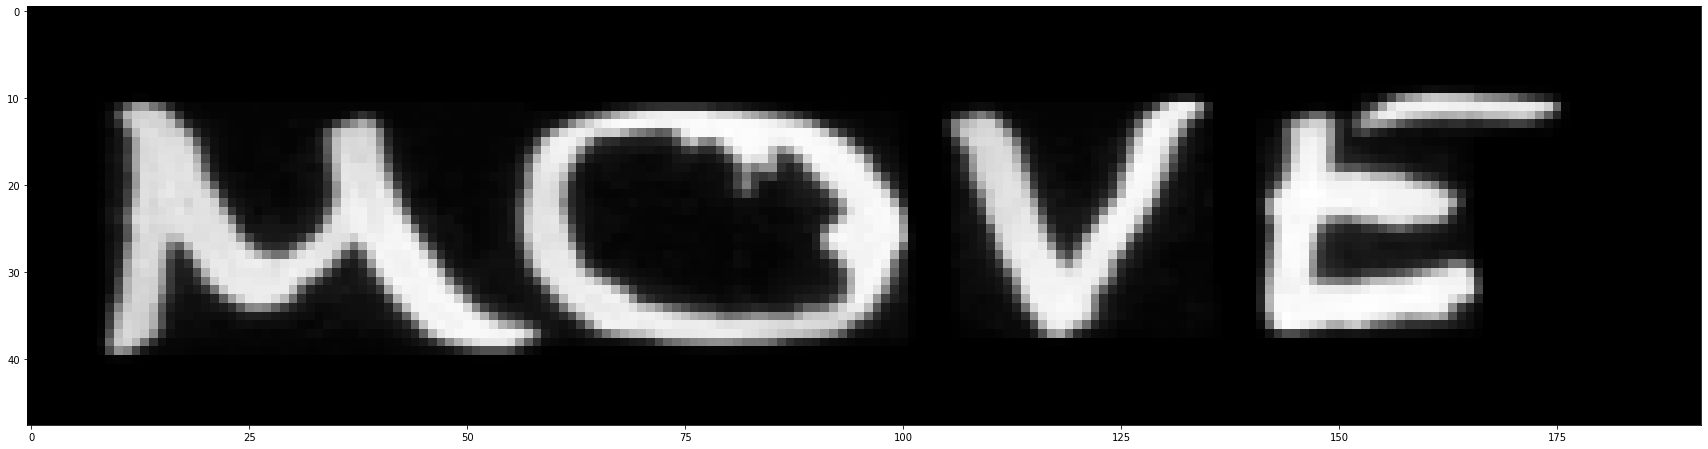

In [33]:
plt.imshow(new_dict['X_trn'][1])

# Plotting an example of preprocessed and raw images

In [4]:
#plt.imshow(new_dict['X_trn'][1], cmap='gray')

In [5]:
#plt.imshow(new_dict_raw['X_trn'][1], cmap='gray')

# Transformations
Slope, slant and elastic transformations that we will apply to the normalised images. These will be the condition images of our Pix2Pix preprocessing architecture.

In [6]:
'''
def get_bbox(img):
    
    height = img.shape[0]
    width = img.shape[1]
    a = np.where(img != 0) 
    
    bottom = np.max(a[0])
    right = np.max(a[1])
    x = np.min(a[1])
    y = np.min(a[0])

    bbox = img[y:bottom+1, x:right+1]    
    w = bbox.shape[1]
    h = bbox.shape[0]
    
    bbox_params = [x, y, w, h]
    
    left_margin = x
    right_margin = width - right
    top_margin = y
    bottom_margin = height - bottom
    
    margin_sizes = [left_margin, right_margin, top_margin, bottom_margin]
    
    return bbox, bbox_params, margin_sizes
'''

'\ndef get_bbox(img):\n    \n    height = img.shape[0]\n    width = img.shape[1]\n    a = np.where(img != 0) \n    \n    bottom = np.max(a[0])\n    right = np.max(a[1])\n    x = np.min(a[1])\n    y = np.min(a[0])\n\n    bbox = img[y:bottom+1, x:right+1]    \n    w = bbox.shape[1]\n    h = bbox.shape[0]\n    \n    bbox_params = [x, y, w, h]\n    \n    left_margin = x\n    right_margin = width - right\n    top_margin = y\n    bottom_margin = height - bottom\n    \n    margin_sizes = [left_margin, right_margin, top_margin, bottom_margin]\n    \n    return bbox, bbox_params, margin_sizes\n'

In [7]:
'''
def erosion(img, kernel_size=2):
    # Sueiras et al. set kernel_size to 3, but visual inspection of the dilated/eroded images 
    # suggests that 2 is a more reasonable and less extreme kernel size
    kernel = np.ones((kernel_size, kernel_size), 'uint8')
    eroded = cv2.erode(img, kernel, iterations=1)
    visible_pixels = len(np.where(eroded > 100)[0]) # the eroded text should be readable (> 100 in a scale 0-255)
    if visible_pixels > 50: # at least one character (~ 50 pixels) must be visible, not just one isolated pixel
        eroded = eroded
        
    else:
        eroded = img
        
    return eroded
'''

"\ndef erosion(img, kernel_size=2):\n    # Sueiras et al. set kernel_size to 3, but visual inspection of the dilated/eroded images \n    # suggests that 2 is a more reasonable and less extreme kernel size\n    kernel = np.ones((kernel_size, kernel_size), 'uint8')\n    eroded = cv2.erode(img, kernel, iterations=1)\n    visible_pixels = len(np.where(eroded > 100)[0]) # the eroded text should be readable (> 100 in a scale 0-255)\n    if visible_pixels > 50: # at least one character (~ 50 pixels) must be visible, not just one isolated pixel\n        eroded = eroded\n        \n    else:\n        eroded = img\n        \n    return eroded\n"

In [8]:
'''
def dilation(img, margin_sizes, kernel_size=2):
    # Sueiras et al. set kernel_size to 3, but visual inspection of the dilated/eroded images 
    # suggests that 2 is a more reasonable and less extreme kernel size
    pixel_excess = math.ceil((kernel_size - 1)//2) # number of pixels that might overflow the image limits
    # after dilation
    condition = np.any(np.array(margin_sizes) < pixel_excess) # if we overflow the image limits
    if condition == True:
        dilated = img # we don't do anything
        
    else:
        kernel = np.ones((kernel_size, kernel_size), 'uint8')
        dilated = cv2.dilate(img, kernel, iterations=1)
        
    return dilated
'''

"\ndef dilation(img, margin_sizes, kernel_size=2):\n    # Sueiras et al. set kernel_size to 3, but visual inspection of the dilated/eroded images \n    # suggests that 2 is a more reasonable and less extreme kernel size\n    pixel_excess = math.ceil((kernel_size - 1)//2) # number of pixels that might overflow the image limits\n    # after dilation\n    condition = np.any(np.array(margin_sizes) < pixel_excess) # if we overflow the image limits\n    if condition == True:\n        dilated = img # we don't do anything\n        \n    else:\n        kernel = np.ones((kernel_size, kernel_size), 'uint8')\n        dilated = cv2.dilate(img, kernel, iterations=1)\n        \n    return dilated\n"

In [9]:
'''
def zoom_X(img):
    factor_X = random.uniform(0.9, 1.1) # 10% at most for zoom out or zoom
    new_width = math.ceil(factor_X*img.shape[1])
    dsize = (new_width, img.shape[0])
    zoomed_X = cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)
    return zoomed_X
'''

'\ndef zoom_X(img):\n    factor_X = random.uniform(0.9, 1.1) # 10% at most for zoom out or zoom\n    new_width = math.ceil(factor_X*img.shape[1])\n    dsize = (new_width, img.shape[0])\n    zoomed_X = cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)\n    return zoomed_X\n'

In [10]:
'''
def zoom_Y(img):
    factor_Y = random.uniform(0.9, 1.1) # 10% at most for zoom out or zoom
    new_height = math.ceil(factor_Y*img.shape[0])
    dsize = (img.shape[1], new_height)
    zoomed_Y = cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)
    return zoomed_Y
'''

'\ndef zoom_Y(img):\n    factor_Y = random.uniform(0.9, 1.1) # 10% at most for zoom out or zoom\n    new_height = math.ceil(factor_Y*img.shape[0])\n    dsize = (img.shape[1], new_height)\n    zoomed_Y = cv2.resize(img, dsize, interpolation = cv2.INTER_AREA)\n    return zoomed_Y\n'

In [11]:
'''
def resize(new_img, src_img):
    
    height = src_img.shape[0]
    new_height = new_img.shape[0]
    width = src_img.shape[1] 
    new_width = new_img.shape[1]
    
    width_ratio = width/new_width
    height_resized = math.ceil(new_height*width_ratio)

    height_ratio = height/new_height
    width_resized = math.ceil(new_width*height_ratio)
    
    if new_width > width or new_height > height:
        
        if height_resized < height:
            
            dsize = (width, height_resized)
            img_rescaled = cv2.resize(new_img, dsize, interpolation = cv2.INTER_AREA)
            
        else:
            dsize = (width_resized, height)
            img_rescaled = cv2.resize(new_img, dsize, interpolation = cv2.INTER_AREA)
            
    else:
        img_rescaled = new_img
           
    return img_rescaled
'''

'\ndef resize(new_img, src_img):\n    \n    height = src_img.shape[0]\n    new_height = new_img.shape[0]\n    width = src_img.shape[1] \n    new_width = new_img.shape[1]\n    \n    width_ratio = width/new_width\n    height_resized = math.ceil(new_height*width_ratio)\n\n    height_ratio = height/new_height\n    width_resized = math.ceil(new_width*height_ratio)\n    \n    if new_width > width or new_height > height:\n        \n        if height_resized < height:\n            \n            dsize = (width, height_resized)\n            img_rescaled = cv2.resize(new_img, dsize, interpolation = cv2.INTER_AREA)\n            \n        else:\n            dsize = (width_resized, height)\n            img_rescaled = cv2.resize(new_img, dsize, interpolation = cv2.INTER_AREA)\n            \n    else:\n        img_rescaled = new_img\n           \n    return img_rescaled\n'

In [12]:
'''
def fitting(src_img, new_bbox, bbox, bbox_params, margin_sizes):
    
    height = src_img.shape[0]
    width = src_img.shape[1]
    x, y, w, h = bbox_params # parameters of the original bbox to put the top-left edge of the new bbox in the first's position
    left_margin, right_margin, top_margin, bottom_margin = margin_sizes
    
    new_height = new_bbox.shape[0]
    new_width = new_bbox.shape[1]
    new_img = np.ones_like(src_img)*np.min(new_bbox)
    
    #new_img[(height - new_height)//2:-(height - new_height)//2, (width - new_width)//2:-(width - new_width)//2] = new_bbox
    
    fits_vertical = new_height + top_margin < height
    fits_horizont = new_width + left_margin < width

    if fits_vertical == False and fits_horizont == False:
        
        diff_vertical = (new_height + top_margin) - height
        diff_horizont = (new_width + left_margin) - width
        new_x = x - diff_horizont
        new_y = y - diff_vertical
        
        new_img[new_y:(new_y + new_height), new_x:(new_x + new_width)] = new_bbox
        
    elif fits_vertical == False and fits_horizont == True:
        
        diff_vertical = (new_height + top_margin) - height
        new_x = x
        new_y = y - diff_vertical
        new_img[new_y:(new_y + new_height), new_x:(new_x + new_width)] = new_bbox
        
    elif fits_vertical == True and fits_horizont == False:
        
        diff_horizont = (new_width + left_margin) - width
        new_x = x - diff_horizont
        new_y = y
        new_img[new_y:(new_y + new_height), new_x:(new_x + new_width)] = new_bbox
        
    else:
        new_x = x
        new_y = y
        new_img[new_y:(new_y + new_height), new_x:(new_x + new_width)] = new_bbox
        
    #new_bbox_params = [new_x, new_y, new_width, new_height]

    return new_img
'''

"\ndef fitting(src_img, new_bbox, bbox, bbox_params, margin_sizes):\n    \n    height = src_img.shape[0]\n    width = src_img.shape[1]\n    x, y, w, h = bbox_params # parameters of the original bbox to put the top-left edge of the new bbox in the first's position\n    left_margin, right_margin, top_margin, bottom_margin = margin_sizes\n    \n    new_height = new_bbox.shape[0]\n    new_width = new_bbox.shape[1]\n    new_img = np.ones_like(src_img)*np.min(new_bbox)\n    \n    #new_img[(height - new_height)//2:-(height - new_height)//2, (width - new_width)//2:-(width - new_width)//2] = new_bbox\n    \n    fits_vertical = new_height + top_margin < height\n    fits_horizont = new_width + left_margin < width\n\n    if fits_vertical == False and fits_horizont == False:\n        \n        diff_vertical = (new_height + top_margin) - height\n        diff_horizont = (new_width + left_margin) - width\n        new_x = x - diff_horizont\n        new_y = y - diff_vertical\n        \n        new_img[n

In [13]:
'''
def displacement(new_img, new_bbox_params, d_x):
    # d_x has to be the amount of pixels
    new_x, new_y, new_width, new_height = new_bbox_params
    total_width = new_x + new_width + d_x
    if total_width > new_img.shape[1]:
        new_img_disp = new_img
        
    else:
        new_img_disp = new_img
        new_img_disp[:, d_x:] = new_img_disp[:, 0:-d_x]
        new_img_disp[:, 0:d_x] = np.min(new_img)
        
    return new_img_disp
'''

'\ndef displacement(new_img, new_bbox_params, d_x):\n    # d_x has to be the amount of pixels\n    new_x, new_y, new_width, new_height = new_bbox_params\n    total_width = new_x + new_width + d_x\n    if total_width > new_img.shape[1]:\n        new_img_disp = new_img\n        \n    else:\n        new_img_disp = new_img\n        new_img_disp[:, d_x:] = new_img_disp[:, 0:-d_x]\n        new_img_disp[:, 0:d_x] = np.min(new_img)\n        \n    return new_img_disp\n'

In [14]:
'''
# Alternative distortions via albumentations (paper by Simard et al. 2003)

def elastic_warp(original, alpha=16, sigma=8, alpha_affine=1):
    
    elastic = albumentations.augmentations.geometric.transforms.ElasticTransform(alpha=alpha, sigma=sigma, alpha_affine=1, 
                                                                                 interpolation=1, border_mode=0, value=None, 
                                                                                 mask_value=None, always_apply=False,
                                                                                 approximate=True, same_dxdy=False, p=1)

    # Enlarging original word image in order to avoid being cropped after elastic transformation   

    nh, nw = original.shape
    dw = nw//2 # left and right margins
    dh = nh//2 # bottom and top margins
    img = cv2.copyMakeBorder(original, dh, dh, dw, dw, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    # Bounding box of the original image

    original_bbox, original_bbox_params, original_margin_sizes = get_bbox(original)

    # Applying elastic transformation to the enlarged image

    elastic_transf = elastic(image = img)
    bbox, bbox_params, margin_sizes = get_bbox(elastic_transf['image'])
    new_img = bbox
    #img_rescaled = resize(new_img, original)
    #new_img, new_bbox_params = fitting(original, img_rescaled, original_bbox, original_bbox_params, original_margin_sizes)

    return new_img
'''

"\n# Alternative distortions via albumentations (paper by Simard et al. 2003)\n\ndef elastic_warp(original, alpha=16, sigma=8, alpha_affine=1):\n    \n    elastic = albumentations.augmentations.geometric.transforms.ElasticTransform(alpha=alpha, sigma=sigma, alpha_affine=1, \n                                                                                 interpolation=1, border_mode=0, value=None, \n                                                                                 mask_value=None, always_apply=False,\n                                                                                 approximate=True, same_dxdy=False, p=1)\n\n    # Enlarging original word image in order to avoid being cropped after elastic transformation   \n\n    nh, nw = original.shape\n    dw = nw//2 # left and right margins\n    dh = nh//2 # bottom and top margins\n    img = cv2.copyMakeBorder(original, dh, dh, dw, dw, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))\n\n    # Bounding box of the original 

In [15]:
'''
def DataAugmentation(img):
    
    src_img = img.copy()
    bbox, bbox_params, margin_sizes = get_bbox(img)
    
    # Erosion/Dilation:
    if random.random() < 0.33:   # ~33% of the images are eroded
        img = erosion(img)
        
    elif random.random() < 0.33: # ~33% of the images are dilated
        img = dilation(img, margin_sizes)
       
    img, _, _ = get_bbox(img) # we have a new bbox after er./dil.  
    
    #Rotation:
    if (random.random() < 0.5 and img.max() > 0): # to perform a rotation we need a non-zero matrix
        angle = random.uniform(-10, 10)
        img = ndimage.rotate(img, angle, reshape=True)
        img, _, _ = get_bbox(img) # ... we'll get a new bbox after rotation
    
    #Zoom in X axis:
    if random.random() < 0.5:
        img = zoom_X(img)
              
    #Zoom in Y axis:
    if random.random() < 0.5:
        img = zoom_Y(img)
            
    # Warp distortion:
    if random.random() < 0.5:
        img = elastic_warp(img)

    
    #Displacement:
    #p_disp = random.uniform(0,1)
    #if p_disp < 0.7:
    #    percentage_disp = random.uniform(0,0.1)
    #    d_x = math.ceil(percentage_disp*img.shape[1])
    #    new_img = displacement(new_img, new_bbox_params, d_x)
    #    
    #else:
    #    new_img = new_img
    
    
    # Rescaling the new bbox in order to fit in the 48x192 original format:
    img = resize(img, src_img)
    
    # Pasting the new bbox in the 48x192 image
    img = fitting(src_img, img, bbox, bbox_params, margin_sizes)
    
    # Normalisation
    img = img / 255
    
    # Salt & Pepper noise:
    if random.random() < 0.5:
        img = skimage.util.random_noise(img, mode = 's&p', amount = 0.10)
    
    return img
'''

"\ndef DataAugmentation(img):\n    \n    src_img = img.copy()\n    bbox, bbox_params, margin_sizes = get_bbox(img)\n    \n    # Erosion/Dilation:\n    if random.random() < 0.33:   # ~33% of the images are eroded\n        img = erosion(img)\n        \n    elif random.random() < 0.33: # ~33% of the images are dilated\n        img = dilation(img, margin_sizes)\n       \n    img, _, _ = get_bbox(img) # we have a new bbox after er./dil.  \n    \n    #Rotation:\n    if (random.random() < 0.5 and img.max() > 0): # to perform a rotation we need a non-zero matrix\n        angle = random.uniform(-10, 10)\n        img = ndimage.rotate(img, angle, reshape=True)\n        img, _, _ = get_bbox(img) # ... we'll get a new bbox after rotation\n    \n    #Zoom in X axis:\n    if random.random() < 0.5:\n        img = zoom_X(img)\n              \n    #Zoom in Y axis:\n    if random.random() < 0.5:\n        img = zoom_Y(img)\n            \n    # Warp distortion:\n    if random.random() < 0.5:\n        img =

In [16]:
'''
def get_Data_Aug(image_set, n_channels=1, height=48, width=192):
    set_length = len(image_set)
    images_da = torch.empty((set_length, n_channels, height, width), dtype=torch.float)
    counter = 0
    for image in image_set:
        try:
            if random.random() > 0.3:
                image = DataAugmentation(image) # normalisation included
                image = torch.FloatTensor(image)
                images_da[counter, :, :, :] = image
                counter += 1
            else:
                image = image / 255 # normalisation
                image = torch.FloatTensor(image)
                images_da[counter, :, :, :] = image
                counter += 1
        except:
            image = image / 255 # normalisation
            image = torch.FloatTensor(image)
            images_da[counter, :, :, :] = image
            counter += 1

    return images_da
'''

'\ndef get_Data_Aug(image_set, n_channels=1, height=48, width=192):\n    set_length = len(image_set)\n    images_da = torch.empty((set_length, n_channels, height, width), dtype=torch.float)\n    counter = 0\n    for image in image_set:\n        try:\n            if random.random() > 0.3:\n                image = DataAugmentation(image) # normalisation included\n                image = torch.FloatTensor(image)\n                images_da[counter, :, :, :] = image\n                counter += 1\n            else:\n                image = image / 255 # normalisation\n                image = torch.FloatTensor(image)\n                images_da[counter, :, :, :] = image\n                counter += 1\n        except:\n            image = image / 255 # normalisation\n            image = torch.FloatTensor(image)\n            images_da[counter, :, :, :] = image\n            counter += 1\n\n    return images_da\n'

In [17]:
'''
def transformations(img):
    
    #Performs random transformations (slant, slope and elastic distortions)
    #to the normalised images
    
    # Random shear:
    if random.uniform(0,1) < 0.75:
        shear_angle = -random.uniform(0,1)
        M = np.float32([[1, -shear_angle, 0.5*img.shape[0]*shear_angle], [0, 1, 0]])
        img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)
    # Random slope:
    if random.uniform(0,1) < 0.75:
        rot_angle = random.uniform(-5,5)
        img = ndimage.rotate(img, rot_angle, reshape=False)
    # Random elastic distortion:   
    if random.uniform(0,1) < 0.75:
        img = elastic_warp(original = img)
        
    return img
'''

'\ndef transformations(img):\n    \n    #Performs random transformations (slant, slope and elastic distortions)\n    #to the normalised images\n    \n    # Random shear:\n    if random.uniform(0,1) < 0.75:\n        shear_angle = -random.uniform(0,1)\n        M = np.float32([[1, -shear_angle, 0.5*img.shape[0]*shear_angle], [0, 1, 0]])\n        img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)\n    # Random slope:\n    if random.uniform(0,1) < 0.75:\n        rot_angle = random.uniform(-5,5)\n        img = ndimage.rotate(img, rot_angle, reshape=False)\n    # Random elastic distortion:   \n    if random.uniform(0,1) < 0.75:\n        img = elastic_warp(original = img)\n        \n    return img\n'

In [18]:
'''
def get_transformed_images(image_set):

    #Applies the function 'transformations' to a given set of images

    transformed_images = []
    for image in image_set:
        try:
            transformed = transformations(image)
            transformed_images += [transformed]
        except:
            transformed = image
            transformed_images += [transformed]
    return transformed_images
'''

"\ndef get_transformed_images(image_set):\n\n    #Applies the function 'transformations' to a given set of images\n\n    transformed_images = []\n    for image in image_set:\n        try:\n            transformed = transformations(image)\n            transformed_images += [transformed]\n        except:\n            transformed = image\n            transformed_images += [transformed]\n    return transformed_images\n"

## Batch generator

These functions will extract random batches from the data file.

In [19]:
def sort_by_batch(set_random_sample, set_length, batch_size):
    sorted_set_rs = []
    j = 0
    while (j + batch_size < set_length):
        sorted_set_rs.append(np.sort(set_random_sample[j:j+batch_size]))
        j = j + batch_size
    
    sorted_set_rs.append(np.sort(set_random_sample[j:]))
    sorted_set_rs = np.concatenate(sorted_set_rs)
    return sorted_set_rs

def data_generator(len_set, image_set, random_sampling, size=(1, 48, 192)):
    
    f = h5py.File(path, "r")
    f_raw = h5py.File(path_raw, "r")
    j = 0
    while 1:
    
        indices = random_sampling[j:j+batch_size]
        data_X = f[image_set][indices]
        data_X_raw = f_raw[image_set][indices]
        
        reals = torch.FloatTensor(data_X)
        reals = reals / 255
        reals = reals.view(-1, *size)
        
        conditions = torch.FloatTensor(data_X_raw)
        #conditions = torch.FloatTensor(data_X)
        conditions = conditions / 255
        conditions = conditions.view(-1, *size)
        
        yield conditions, reals
        
        if j + 2*batch_size >= len_set: # drop_last = True
            j = 0
            break
        else:
            j +=  batch_size
        
    f.close()

## U-Net Architecture

Now we will build the U-Net architecture, which is the generator and main component of the Pix2Pix GAN model.

The figure below is from the paper, [*U-Net: Convolutional Networks for Biomedical Image Segmentation*](https://arxiv.org/abs/1505.04597), by Ronneberger et al. 2015. It shows the U-Net architecture and how it contracts and then expands.

<!-- "[i]t consists of a contracting path (left side) and an expansive path (right side)" (Renneberger, 2015) -->

![Figure 1 from the paper, U-Net: Convolutional Networks for Biomedical Image Segmentation](https://drive.google.com/uc?export=view&id=1XgJRexE2CmsetRYyTLA7L8dsEwx7aQZY)

In other words, images are first fed through many convolutional layers which reduce height and width while increasing the channels, which the authors refer to as the "contracting path." For example, a set of two 2 x 2 convolutions with a stride of 2, will take a 1 x 28 x 28 (channels, height, width) grayscale image and result in a 2 x 14 x 14 representation. The "expanding path" does the opposite, gradually growing the image with fewer and fewer channels.

In [20]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels (assumes that the input's size and the new size are
    even numbers).
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - new_shape[2] // 2
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - new_shape[3] // 2
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        #print('original', x.shape)
        x = self.conv1(x)
        #print('conv1', x.shape)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        #print('conv2', x.shape)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        #print('maxpooling', x.shape)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        #print('original', x.shape)
        x = self.upsample(x)
        #print('upsampling', x.shape)
        x = self.conv1(x)
        #print('conv1', x.shape)
        skip_con_x = crop(skip_con_x, x.shape)
        #print('skip connection', x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        #print('concat', x.shape)
        x = self.conv2(x)
        #print('conv2', x.shape)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        #print('conv3', x.shape)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.expand0 = ExpandingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 4)
        self.expand2 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        #print('upfeature', x0.shape)
        x1 = self.contract1(x0)
        #print('contract1', x1.shape)
        x2 = self.contract2(x1)
        #print('contract2', x2.shape)
        x3 = self.contract3(x2)
        #print('contact3', x3.shape)
        x4 = self.expand0(x3, x2)
        #print('expand1', x4.shape)
        x5 = self.expand1(x4, x1)
        #print('expand2', x5.shape)
        x6 = self.expand2(x5, x0)
        #print('expand3', x6.shape)
        xn = self.downfeature(x6)
        #print('downfeature', xn.shape)
        
        return self.sigmoid(xn)

## PatchGAN Discriminator

Next, we will define a discriminator based on the contracting path of the U-Net to allow you to evaluate the realism of the generated images. Recall that for the Pix2Pix architecture, the discriminator outputs a one-channel matrix of classifications instead of a single value. Our discriminator's final layer will simply map from the final number of hidden channels to a single prediction for every pixel of the layer before it.

In [21]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.final = nn.Conv2d(hidden_channels * 4, 1, kernel_size=1)

    def forward(self, x, y):
        #print('x, y', x.shape, y.shape)
        x = torch.cat([x, y], axis=1)
        #print('concatenate', x.shape)
        x0 = self.upfeature(x)
        #print('upfeature', x0.shape)
        x1 = self.contract1(x0)
        #print('conctract1', x1.shape)
        x2 = self.contract2(x1)
        #print('contract2', x2.shape)
        xn = self.final(x2)
        #print('final', xn.shape)
        
        return xn

## Training Preparation

Now we can begin putting everything together for training. We start by defining some new parameters:
  *   **real_dim**: the number of channels of the real image and the number expected in the output image
  *   **adv_criterion**: an adversarial loss function to keep track of how well the GAN is fooling the discriminator and how well the discriminator is catching the GAN
  *   **recon_criterion**: a loss function that rewards similar images to the ground truth, which "reconstruct" the image
  *   **lambda_recon**: a parameter for how heavily the reconstruction loss should be weighed
  *   **n_epochs**: the number of times you iterate through the entire dataset when training
  *   **input_dim**: the number of channels of the input image
  *   **display_step**: how often to display/visualize the images
  *   **batch_size**: the number of images per forward/backward pass
  *   **lr**: the learning rate
  *   **target_shape**: the size of the output image (in pixels)
  *   **device**: the device type

In [22]:
import torch.nn.functional as F
# New parameters
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 50

len_trn = 47926
len_val = 7558
n_epochs = 500000
input_dim = 1
real_dim = 1
display_step = 25
batch_size = 128
lr = 0.0002
target_shape = (48, 192)
device = 'cuda:0'

We will then pre-process the images of the dataset to make sure they're all the same size and that the size change due to U-Net layers is accounted for. 

Next, we can initialize your generator (U-Net) and discriminator, as well as their optimizers. Finally, we could also load our pre-trained model.

In [23]:
gen = UNet(input_dim, real_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Feel free to change pretrained to False if you're training the model from scratch
pretrained = False
if pretrained:
    loaded_state = torch.load("pix2pix_15000.pth")
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
else:
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

While there are some changes to the U-Net architecture for Pix2Pix, the most important distinguishing feature of Pix2Pix is its adversarial loss. We will be implementing that here!

In [24]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: get_gen_loss
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator; takes the condition and returns potential images
        disc: the discriminator; takes images and the condition and
          returns real/fake prediction matrices
        real: the real images (e.g. normalised) to be used to evaluate the reconstruction
        condition: the source images (e.g. unnormalised) which are used to produce the real images
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the true labels and returns a adversarial 
                  loss (which you aim to minimize)
        recon_criterion: the reconstruction loss function; takes the generator 
                    outputs and the real images and returns a reconstructuion 
                    loss (which you aim to minimize)
        lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
    '''
    # Steps: 1) Generate the fake images, based on the conditions.
    #        2) Evaluate the fake images and the condition with the discriminator.
    #        3) Calculate the adversarial and reconstruction losses.
    #        4) Add the two losses, weighting the reconstruction loss appropriately.
    fake = gen(condition)
    disc_fake_hat = disc(fake, condition)
    gen_adv_loss = adv_criterion(disc_fake_hat, torch.ones_like(disc_fake_hat))
    gen_rec_loss = recon_criterion(real, fake)
    gen_loss = gen_adv_loss + lambda_recon * gen_rec_loss
    
    return gen_loss

## Pix2Pix Training



In [25]:
from skimage import color
import numpy as np
random.seed(111)

def train(epoch, image_to_tensorboard):
    train_losses = []
    mean_generator_loss = 0
    mean_discriminator_loss = 0

    random_sampling = random.sample(range(len_trn), len_trn)
    random_sampling = sort_by_batch(random_sampling, len_trn, batch_size)
    train_loader = data_generator(len_trn, image_set = 'X_trn', random_sampling = random_sampling)
    
    cur_step = 0

    for conditions_trn, reals_trn in tqdm(train_loader, total=int(len_trn / batch_size)):
        cur_batch_size = len(conditions_trn)
        conditions_trn = conditions_trn.to(device)
        reals_trn = reals_trn.to(device)

        ### Update discriminator ###
        disc_opt.zero_grad() # Zero out the gradient before backpropagation
        with torch.no_grad():
            fake = gen(conditions_trn)
        disc_fake_hat = disc(fake.detach(), conditions_trn) # Detach generator
        disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
        disc_real_hat = disc(reals_trn, conditions_trn)
        disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True) # Update gradients
        disc_opt.step() # Update optimizer

        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, reals_trn, conditions_trn, adv_criterion, recon_criterion, lambda_recon)
        gen_loss.backward() # Update gradients
        gen_opt.step() # Update optimizer
        
        train_losses += [gen_loss.item()]

        cur_step += 1
        
    return np.mean(train_losses)

In [26]:
from skimage import color
import numpy as np
random.seed(111)

def validation(epoch, image_to_tensorboard, writer, tensorboard_img_step):
    validation_losses = []
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    
    random_sampling = random.sample(range(len_val), len_val)
    random_sampling = sort_by_batch(random_sampling, len_val, batch_size)
    val_loader = data_generator(len_val, image_set = 'X_val', random_sampling = random_sampling)
    
    cur_step = 0
    
    with torch.no_grad():
        for conditions_val, reals_val in tqdm(val_loader, total=int(len_val / batch_size)):
            cur_batch_size = len(conditions_val)
            conditions_val = conditions_val.to(device)
            reals_val = reals_val.to(device)

            ### Update discriminator ###
            fake = gen(conditions_val)

            disc_fake_hat = disc(fake.detach(), conditions_val) # Detach generator
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            disc_real_hat = disc(reals_val, conditions_val)
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2

            ### Update generator ###
            gen_loss = get_gen_loss(gen, disc, reals_val, conditions_val, adv_criterion, recon_criterion, lambda_recon)

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            validation_losses += [gen_loss.item()]
            
            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                else:
                    print("Raw, pre-processed and generated images")

                condition_images = show_tensor_images(conditions_val, size=(input_dim, *target_shape))
                real_images = show_tensor_images(reals_val, size=(real_dim, *target_shape))
                fake_images = show_tensor_images(fake, size=(real_dim, *target_shape))
                '''
                if image_to_tensorboard:
                    
                    writer.add_image('Images/Condition', condition_images, tensorboard_img_step)
                    writer.add_image('Images/Real', real_images, tensorboard_img_step)
                    writer.add_image('Images/Fake', fake_images, tensorboard_img_step)
                    
                    tensorboard_img_step += display_step
                '''   
                mean_generator_loss = 0
                mean_discriminator_loss = 0
            
            cur_step += 1
            
    return np.mean(validation_losses), tensorboard_img_step

In [27]:
class Patience():
    
    def __init__(self, save_model, patience):
        self.save_model = save_model
        self.patience = patience
        self.current_patience = patience
        self.min_loss_val = float('inf')
        
    def more_patience(self,loss_val):
        self.current_patience -= 1
        if self.current_patience == 0:
            return False

        if loss_val < self.min_loss_val:
            self.min_loss_val = loss_val
            self.current_patience = patience
            '''
            if self.save_model:
                model_name = f"IAM_Gen_lambda_50_from_raw_to_preprocessed.pt"
                print("Saved best model.")
                
                torch.save({'gen_IAM_txt': gen.state_dict(),
                            'gen_opt_IAM_txt': gen_opt.state_dict(),
                            'disc_IAM_txt': disc.state_dict(),
                            'disc_opt_IAM_txt': disc_opt.state_dict()
                        }, model_name)
                
                torch.save(gen.state_dict(), 'Gen_'+model_name)
                torch.save(disc.state_dict(), 'Disc_'+model_name)
            '''
        return True

In [28]:
#from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()

torch.manual_seed(111)
patience = 200
add_to_tensorboard = True
image_to_tensorboard = True
save_model = True
tensorboard_img_step = 0

patience_controler = Patience(save_model, patience)

for num_epoch in range(n_epochs):

    train_loss = train(epoch=num_epoch, image_to_tensorboard=image_to_tensorboard)        
    valid_loss, tensorboard_img_step = validation(epoch=num_epoch, image_to_tensorboard=image_to_tensorboard,
                                                  writer=None, tensorboard_img_step=tensorboard_img_step)
    '''
    if add_to_tensorboard:
        writer.add_scalar('GenLoss/training', train_loss, num_epoch)
        writer.add_scalar('GenLoss/validation', valid_loss, num_epoch)
    '''           
    if not patience_controler.more_patience(valid_loss):
        print("NO MORE PATIENCE!")
        break

upfeature torch.Size([128, 32, 48, 192])
contract1 torch.Size([128, 64, 24, 96])
contract2 torch.Size([128, 128, 12, 48])
contact3 torch.Size([128, 256, 6, 24])
expand1 torch.Size([128, 128, 12, 48])
expand2 torch.Size([128, 64, 24, 96])
expand3 torch.Size([128, 32, 48, 192])
downfeature torch.Size([128, 1, 48, 192])
upfeature torch.Size([128, 32, 48, 192])
contract1 torch.Size([128, 64, 24, 96])
contract2 torch.Size([128, 128, 12, 48])
contact3 torch.Size([128, 256, 6, 24])
expand1 torch.Size([128, 128, 12, 48])
expand2 torch.Size([128, 64, 24, 96])
expand3 torch.Size([128, 32, 48, 192])
downfeature torch.Size([128, 1, 48, 192])
upfeature torch.Size([128, 32, 48, 192])
contract1 torch.Size([128, 64, 24, 96])
contract2 torch.Size([128, 128, 12, 48])
contact3 torch.Size([128, 256, 6, 24])
expand1 torch.Size([128, 128, 12, 48])
expand2 torch.Size([128, 64, 24, 96])
expand3 torch.Size([128, 32, 48, 192])
downfeature torch.Size([128, 1, 48, 192])
upfeature torch.Size([128, 32, 48, 192])
co